# ASDC Data Processing Tool (Version 1)


The following notebook downloads tropospheric nitrogen dioxide column data from NASA's Troposoperic Emissions: Monitoring of Pollution (TEMPO) instrument.

For validation, the notebook also downloads tropospheric nitrogen dioxide column data from the Pandonia Global Network (PGN), as well as meteorological variables from NASA's Power Project, and ground sensor variables captured using Environmental Protection Agencies (EPA)'s AirNow sensors via pyrsig. 

Additional information on all downloaded data can be found at the links below.

- [TEMPO](https://www.earthdata.nasa.gov/data/instruments/tempo)
- [PANDORA](https://pandora.gsfc.nasa.gov/)
- [POWER](https://power.larc.nasa.gov/data-access-viewer/)
- [AIRNOW](https://gaftp.epa.gov/Air/aqmg/bhenders/presentations/pyrsig_2023-07-20.pdf)

For further validation assessment, we perform Linear Regression, Ridge Regression, and Random Forest on provided variables over defined time frame.

## User Requirements
- User must have a NASA earthaccess account
- Notebook assumes execution in local directory


## Notes on TEMPO NO2 validation
This notebook illustrates comparison of nitrogen dioxide tropospheric column retrievals by TEMPO and Pandora ground stations.

It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibilty to select the station within TEMPO's field of regard (FOR). If the selected station is outside FOR, no TEMPO time series will be generated.

The user is allowed to choose the time period of interest by providing start and end dates in the form YYYYMMDD. Please be aware, that if the selecte period of interest is outside of available time span of one of the sensors, corresponding time series will not be generated.

Data files for both sensors are downloaded on-the-fly. TEMPO data are downloaded with earthaccess library that needs to be installed first.

TEMPO data files are read by means of netCDF library that needs to be installed first.

Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read nitrogen dioxide total column along with its total uncertainty.

This code takes into account quality flags (QFs) from both TEMPO and Pandora. This is implemented as follow. On the TEMPO side, data set "/product/main_data_quality_flag" is read, all pixels with non-zero QFs are discarded. However, negative values of tropospheric NO2 column are NOT discarded and used for averaging/interpolationg to the point of interest. For the purpose of physical sanity, another way is also implemented, i.e., negative retrievals are not used in averaging. Therefore, TWO values are returned, trop_NO2_col, and trop_NO2_col_noneg. On Pandora side negative columns also occur despite high quality flags, though they are rare. So, two Pandora time series are considered - with and without negative columns.

The resulting time series are plotted with and without uncertainty of both measurement in the end of the notebook.

This notebook is tested on TEMPO_NO2_L2_V03 and Pandora L2_rnvh3p1-8 files.

In [1]:
!python -m pip install -qq pyproj pyrsig opencv-python netCDF4 earthaccess

Importing necessary libraries

In [2]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data
import os
import sys
import re
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
import platform
from subprocess import Popen
import shutil
import seaborn as sns
from tqdm import tqdm
from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest
from scipy import stats # needed for linear regression analysis

import requests # needed to search for and download Pandora data
import codecs # needed to   read Pandora data
import numpy as np

import matplotlib.pyplot as plt # needed to plot the resulting time series
from urllib.request import urlopen, Request # needed to search for and download Pandora data
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime, timedelta # needed to work with time in plotting time series
import math

import joblib
import pyproj
import pyrsig
import pandas as pd
import getpass
import matplotlib.pyplot as plt
import folium
from functools import reduce


from typing import List, Union, Optional
from pathlib import Path
from datetime import date, datetime
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
import time
import os
import pandas as pd
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit, KFold, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from matplotlib.gridspec import GridSpec


from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn import metrics
from PIL import Image
from pathlib import Path
import cv2
pd.set_option('display.max_columns', None)
from scipy.stats import zscore
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel as C, RationalQuadratic


# Establishing access to EarthData
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

##creating local directory
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /home/jovyan/


In [3]:
# functions to work with pandora
## function creating the list of available Pandora Sites
# function read_pandora_web returns the list of available Pandora sites
def read_pandora_web():
  url = 'https://data.pandonia-global-network.org/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  refs = []
  for line in ref_lines:
    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and line[pos1+1] == '.':
      refs.append(line[pos1+3 : pos2-1])

  return refs
##functions allowing user to choose a Pandora site of interest
# function check_site checks whether user entered site is in the list of available Pandora sites
def check_site(site_name, refs):
  site_list = []
  for line in refs:
    if site_name in line:
      site_list.append(line)

  return site_list


# function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
def take_pandora_sites(refs):
  print('please select a Pandora site name from the list')
  for ref in refs:
    print(ref)

  answer = 'y'
  while answer == 'y':
    site_name = input('Enter a name of a Pandora site: ')
    print(site_name)
    site_list = check_site(site_name, refs)
    site_num = len(site_list)
    if site_num == 0:
      print('site ', site_name, 'was not found')
      continue

    if site_num > 1:
      print('there are ', site_num, ' site names, select one from')
      for site in site_list: print(site)

      site_name = input('Enter a name of a Pandora site: ')
      if site_list.count(site_name) != 1:
        print('Entered name is not the exact match of one of the following sites')
        for site in site_list: print(site)
        print('program terminated')
        sys.exit()

      for site in site_list:
        if site == site_name:
          pandora_site = site_name
          print('site ', site_name, 'was found and added to the list of sites ')
          break

    if site_num == 1:
      pandora_site = site_list[0]
      print('site ', site_list[0], 'was found and added to the list of sites ')

    answer = 'n'

  return pandora_site
##function creating the list of links to tropospheric NO2 data files at the selected Pandora sites and downloading the data files
# Pandora site may have several instruments. In this case each instrument has its own directory.
# However, the most recent version of the troposperic NO2 data, rnvh3p1-8, is available only in one of these directories.
# The function creates all possible links, but some of them may be non-existing. This is checked and cleared later.
def instrument_path(site):
# function instrument_path returns links to possible Pandora NO2 retrievals files
  url = 'https://data.pandonia-global-network.org/' + site + '/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0
  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  links = []
  for line in ref_lines:

    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and\
       line[pos1+3 : pos1 + 10] == 'Pandora':
      link = url + line[pos1+3 : pos2] + 'L2/' + line[pos1+3 : pos2-1] + '_' + site + '_L2_rnvh3p1-8.txt'
      print(link)
      links.append(link)

  return links


# function downloading Pandora data file with given url
def download(url):
  response = requests.get(url)
  response_code = response.status_code

  file_name = url.split('/')[-1]

  if response_code == 200:
    content = response.content
    data_path = Path(file_name)
    data_path.write_bytes(content)

  return file_name, response_code
##unction reading Pandora NO2 data files rnvh3p1-8
# function converting Pandora timestamp into a set of  year, month, day, hour, minute, and second
# function read_timestamp converts Pandora timestamp of the format
# 'yyyymmddThhmmssZ' into a set of 6 numbers:
# integer year, month, day, hour, minute, and real second.
def read_timestamp(timestamp):

  yyyy = int(timestamp[0:4])
  mm = int(timestamp[4:6])
  dd = int(timestamp[6:8])
  hh = int(timestamp[9:11])
  mn = int(timestamp[11:13])
  ss = int(timestamp[13:15])

  return yyyy, mm, dd, hh, mn, ss


# function reading Pandora NO2 data file rnvh3p1-8
#
# Below is the second version of function read_Pandora_NO2_rnvs3p1_8. It is to be used for the future validation efforts.
# The difference with the original version is that instead of discriminating negative values of the total NO2 column,
# it uses quality flags. It was previously found that QF == 0 does not occure often enough,
# so we will have to use QF == 10 (not-assured high quality).
#
# function read_Pandora_NO2_rnvh3p1_8 reads Pandora total NO2 column data files ending with rnvh3p1-8.
# Arguments:
# fname - name file to be read, string;
# start_date - beginning of the time interval of interest,
#              integer of the form YYYYMMDD;
# end_date -   end of the time interval of interest,
#              integer of the form YYYYMMDD.
#
# if start_date is greater than end_date, the function returns a numpy array
# with shape (0, 8), otherwise it returns an 8-column numpy array
# with with columns being year, month, day, hour, minute, second of observation
# and retrieved total NO2 column along with its total uncertainty.
#
# NO2 column is in mol/m^2, so conversion to molecules/cm^2 is performed by
# multiplication by Avogadro constant, NA =  6.02214076E+23, and division by 1.E+4
def read_Pandora_NO2_rnvh3p1_8(fname, start_date, end_date):

  conversion_coeff = 6.02214076E+19 # Avogadro constant divided by 10000

  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., data

  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:

    while True:
# Get next line from file
      line = f.readline()

      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        print('location name ', loc_name)

      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        print('location latitude ', lat)

      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        print('location longitude ', lon)

      if line.find('--------') >= 0: break

    while True:
# Get next line from file
      line = f.readline()
      # print(line)
      if line.find('--------') >= 0: break

    while True:
# now reading line with data
      line = f.readline()
      
      if not line: break

      line_split = line.split()
     
      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      QF = int(line_split[52]) # total column uncertainty

      if QF == 0 or QF == 10:
        column = float(line_split[61]) # Nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        column_unc = float(line_split[62]) # Independent uncertainty of nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        
        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss\
                               , column*conversion_coeff\
                               , column_unc*conversion_coeff]], axis = 0)

  return lat, lon, loc_name, data

def read_Pandora_NO2_rnvm2p1_8(fname, start_date, end_date):  #####################LUNAR
  conversion_coeff = 6.02214076E+19 # Avogadro constant divided by 10000
  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., data

  # with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:
  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:

    while True:
# Get next line from file
      line = f.readline()

      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        # print('location name ', loc_name)

      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        # print('location latitude ', lat)

      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        # print('location longitude ', lon)

      if line.find('--------') >= 0: break

    while True:
# Get next line from file
      line = f.readline()
      # print(line)
      if line.find('--------') >= 0: break

    while True:
# now reading line with data
      line = f.readline()
      
      if not line: break

      line_split = line.split()
     
      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      QF = int(line_split[35])
      
      if QF == 0 or QF == 10 or QF == 1 or QF ==11:
      # if QF:
        column = float(line_split[38])# - float(line_split[52]) # Nitrogen dioxide total vertical column amount [moles per square meter]
        column_unc = float(line_split[39]) # Independent uncertainty of nitrogen dioxide tropospheric vertical column amount [moles per square meter]
        
        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss\
                               , column*conversion_coeff\
                               , column_unc*conversion_coeff]], axis = 0)

  return data

#----------------------------------------------------## TEMPO Functions ##----------------------------------------------------------------------------------------------
#funciton reading TEMPO NO2 data file
# function reading TEMPO NO2 data file for tropospheric column
def read_TEMPO_tropNO2_L2(fn):
  '''
  function read_TEMPO_tropNO2_L2 reads the following arrays from the
  TEMPO L2 NO2 product TEMPO_NO2_L2_V03:
    vertical_column_troposphere;
    vertical_column_troposphere_uncertainty;
  and returns respective fields along with coordinates of the pixels.

  If one requested variables cannot be read, all returned variables are zeroed
  '''
  var_name = 'vertical_column_troposphere'
  var_unc_name = 'vertical_column_troposphere_uncertainty'
  var_QF_name = 'main_data_quality_flag'

  try:
    ds = nc.Dataset(fn)

    prod = ds.groups['product'] # this opens group product, /product, as prod

    var = prod.variables[var_name] # this reads variable column_amount_o3 from prod (group product, /product)
    trop_NO2_column = np.array(var)
    fv_prod = var.getncattr('_FillValue')
    prod_unit = var.getncattr('units')

    var_unc = prod.variables[var_unc_name] # this reads variable column_amount_o3 from prod (group product, /product)
    trop_NO2_column_unc = np.array(var_unc)

    var_QF = prod.variables[var_QF_name] # this reads variable column_amount_o3 from prod (group product, /product)
    trop_NO2_column_QF = np.array(var_QF)
    fv_QF = var_QF.getncattr('_FillValue')

    geo = ds.groups['geolocation'] # this opens group geolocation, /geolocation, as geo

    lat = np.array(geo.variables['latitude']) # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
    lon = np.array(geo.variables['longitude']) # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
    fv_geo = geo.variables['latitude'].getncattr('_FillValue')
    time = np.array(geo.variables['time'] )# this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

    ds.close()

  except:
    print('variable '+var_name+' cannot be read in file '+fn)
    lat = 0.
    lon = 0.
    time = 0.
    fv_geo = 0.
    trop_NO2_column = 0.
    trop_NO2_column_unc = 0.
    trop_NO2_column_QF = 0.
    fv_prod = 0.
    fv_QF = -999
    prod_unit = ''
  return lat, lon, fv_geo, time, trop_NO2_column, trop_NO2_column_unc\
, trop_NO2_column_QF, fv_prod, fv_QF, prod_unit


#-------------------------------------------------## Processing Functions ##---------------------------------------------------------------------------------------
def convert_time(input_value, return_format="datetime"):
    """
    Converts:
    - A date-time string in 'YYYY-MM-DD HH:MM:SS' format to milliseconds since epoch.
    - Milliseconds since epoch to a date-time string or a compact date format ('YYYYMMDD').
    
    Parameters:
    - input_value (str/int/float): The input date-time string or milliseconds since epoch.
    - return_format (str): Output format when converting from milliseconds. 
      Options: "datetime" (default) -> 'YYYY-MM-DD HH:MM:SS'
               "compact" -> 'YYYYMMDD'
    
    Returns:
    - int: Milliseconds since epoch if input is a date-time string.
    - str: Formatted date-time string based on return_format if input is milliseconds.
    """
    if isinstance(input_value, str):  # Convert date-time string to milliseconds
        dt = datetime.strptime(input_value, '%Y-%m-%d %H:%M:%S')
        return int(dt.timestamp() * 1000)
    
    elif isinstance(input_value, (int, float)):  # Convert milliseconds to date-time string
        dt = datetime.fromtimestamp(input_value / 1000)
        
        if return_format == "compact":
            return dt.strftime('%Y%m%d%H')  # Format as 'YYYYMMDD'
        else:
            return dt.strftime('%Y-%m-%d %H:%M:%S')  # Default format

    else:
        raise ValueError("Input must be a date-time string or an integer/float representing milliseconds.")


def convert_to_decimal(coord):
    """Convert coordinates from '38.9262N' format to decimal degrees."""
    match = re.match(r"(\d+\.\d+)([NSEW])", coord)
    if not match:
        raise ValueError(f"Invalid coordinate format: {coord}")
    
    value, direction = float(match.group(1)), match.group(2)
    
    if direction in ['S', 'W']:
        return -value  # South and West are negative
    return value  # North and East are positive

def tempo_processing(text_file, year, save=False, filename = ''):
    with open(text_file, 'r') as file:
        header1 = file.readline()
        header2 = file.readline()
        tempo = file.readlines()
    
        tempo_no2 = {
        'date': [], 'NO2': [] }#, 'NO2_UNC': [], 'LAT_NE': [], 'LON_NE': [], 'NO2_NE': [], 'UNC_NE': [],'LAT_SE': [], 'LON_SE': [], 'NO2_SE': [], 'UNC_SE': [], 'LAT_SW': [], 'LON_SW': [], 'NO2_SW': [],'UNC_SW': [], 'LAT_NW': [], 'LON_NW': [], 'NO2_NW': [], 'UNC_NW': []
    # }
    
        for line in tempo:
            split = line.split()
            seconds = int(float(split[5]))  # Works for both '57.1' and '0.3'
            date = datetime(int(split[0]), int(split[1]), int(split[2]), int(split[3]), int(split[4]), seconds)
            
            tempo_no2['date'].append(date)
            tempo_no2['NO2'].append(int(float(split[6])))
            # tempo_no2['NO2_UNC'].append(int(float(split[7])))
            # tempo_no2['LAT_NE'].append(convert_to_decimal(split[8]))  
            # tempo_no2['LON_NE'].append(convert_to_decimal(split[9]))  
            # tempo_no2['NO2_NE'].append(float(split[10]))  
            # tempo_no2['UNC_NE'].append(float(split[11]))  
            # tempo_no2['LAT_SE'].append(convert_to_decimal(split[12]))  
            # tempo_no2['LON_SE'].append(convert_to_decimal(split[13])) 
            # tempo_no2['NO2_SE'].append(int(float(split[14])))
            # tempo_no2['UNC_SE'].append(int(float(split[15])) )            
            # tempo_no2['LAT_SW'].append(convert_to_decimal(split[16]))  
            # tempo_no2['LON_SW'].append(convert_to_decimal(split[17]))  
            # tempo_no2['NO2_SW'].append(int(float(split[18])))
            # tempo_no2['UNC_SW'].append(int(float(split[19])))
            # tempo_no2['LAT_NW'].append(convert_to_decimal(split[20]))  
            # tempo_no2['LON_NW'].append(convert_to_decimal(split[21]))  
            # tempo_no2['NO2_NW'].append(int(float(split[22])))
            # tempo_no2['UNC_NW'].append(int(float(split[23])))
            
    df = pd.DataFrame(tempo_no2)
    df["year"], df["month"], df["day"], df["hour"] = df["date"].dt.year,df["date"].dt.month, df["date"].dt.day, df["date"].dt.hour
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df.drop(columns = ['date'])
    # df = df.drop_duplicates(subset='datetime', keep= 'first').reset_index(drop=True)
    df = df.groupby('datetime', as_index=False).mean()
    if save: df.to_csv(filename +'.csv',index=False)
    
    return df


def pandora_processing(day_file_path,night_file_path,year=2024, date_start=None, date_end=None, save=False, filename=''):
    # Load raw data and group hourly
    columns = ["year", "month", "day", "hour", "minute", "second", "NO2", "unc", "QF"]
    df = pd.read_csv(day_file_path, sep = '\s+', names=columns)
    # df = df.groupby(["year", "month", "day", "hour"], as_index=False)["NO2"].mean()
    df = df.rename(columns = {'NO2': 'NO2_day'})
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

    if night_file_path is not None:
        df_night = pd.read_csv(night_file_path, sep = '\s+', names=columns)    
        # df_night = df_night.groupby(["year", "month", "day", "hour"], as_index=False)["NO2"].mean()
        df_night['datetime'] = pd.to_datetime(df_night[['year', 'month', 'day', 'hour', 'minute','second']])
        df_night = df_night.rename(columns = {'NO2': 'NO2_night'})

            # Outer merge so we keep all datetimes
        df_merged = pd.merge(df_night[['datetime', 'NO2_night']],
                         df[['datetime', 'NO2_day']],
                         on='datetime',
                         how='outer')

        # full_range = pd.date_range(start=date_start, end=date_end, freq='T')
        # df_full = pd.DataFrame({'datetime': full_range})
    
        # pandora = pd.merge(df_full, df_merged, on='datetime', how='left')
        
        # pandora['NO2_pan'] = pandora['NO2_day'].combine_first(pandora['NO2_night'])
        z_scores = zscore(df_merged['NO2_night'].dropna())
        z_thresh = 3  # Typical threshold for outliers
        valid_index = df_merged['NO2_night'].dropna().index
        outlier_index = valid_index[abs(z_scores) > z_thresh]
        df_merged.loc[outlier_index, 'NO2_night'] = pd.NA    
        # pandora['NO2_pan'] = pandora['NO2_day'].combine_first(pandora['NO2_night'])
    
    else: #daytime only data...
        # Set date boundaries
        min_date = df["date"].min().normalize() if date_start is None else pd.Timestamp(date_start)
        max_date = df["date"].max().normalize() if date_end is None else pd.Timestamp(date_end)
        full_date_range = pd.date_range(min_date, max_date, freq='T')
        
        # Build sun dataframe holding per-day hour range
        sun = []
        for (y, m, d), group in df.groupby(["year", "month", "day"]):
            hour_range = sorted(group["hour"].unique())
            sun.append({
                'year': y,
                'month': m,
                'day': d,
                'datetime': pd.Timestamp(f"{y}-{m:02d}-{d:02d}"),
                'date_range_start': hour_range[0],
                'date_range_end': hour_range[-1]
            })
        sun_df = pd.DataFrame(sun)
        sun_df = sun_df.sort_values('datetime')
        
        # Track last seen hour range for filling entire missing days
        last_range = None
        all_rows = []
        
        for day in full_date_range:
            match = sun_df[sun_df["datetime"] == day]
            if not match.empty:
                # Data exists for this day; use its range
                start_h, end_h = int(match.iloc[0]["date_range_start"]), int(match.iloc[0]["date_range_end"])
                last_range = (start_h, end_h)
            elif last_range is not None:
                # No data; use last seen hour range
                start_h, end_h = last_range
            else:
                continue  # No data yet to define a range, skip this day
            
            # Add rows for all hours in the day/hourrange
            for hour in range(start_h, end_h + 1):
                all_rows.append({
                    "year": day.year,
                    "month": day.month,
                    "day": day.day,
                    "hour": hour,
                    "datetime": pd.Timestamp(f"{day.date()} {hour:02d}:00:00")
                })
    
        # Build and merge final DataFrame
        skeleton_df = pd.DataFrame(all_rows)
        pandora = pd.merge(skeleton_df, df, on=["year","month","day","hour","datetime"], how="left").sort_values(["datetime"])
        pandora = pandora.drop(columns = ['year' ,'month', 'day', 'hour'])
        pandora = pandora.rename(columns = {'NO2_day': 'NO2_pan'})

        # Optional save
    # if save and filename:
    #     merged.to_csv(filename+'.csv', index=False)
        
    return df_merged

def power_processing(powercsv_path, year=2025, save=False, filename=''):
    power = pd.read_csv(powercsv_path, skiprows=range(0, 19))
    power = power.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'})
    power['datetime'] = pd.to_datetime(power[['year', 'month', 'day', 'hour']])
    power = power.drop(columns=['ALLSKY_SFC_SW_DWN','CLOUD_AMT', 'year', 'month', 'day', 'hour'])
    return power


def get_rectangle_polygon(lat, lon, width_km, height_km):
    earth_radius_km = 6371.0 
    # Compute half-width and half-height in degrees
    delta_lat = (height_km / 2) / 111.32  # 1 degree latitude ≈ 111.32 km
    delta_lon = (width_km / 2) / (111.32 * math.cos(math.radians(lat)))  # Adjust for longitude

    top_left = (lat + delta_lat, lon - delta_lon)
    top_right = (lat + delta_lat, lon + delta_lon)
    bottom_right = (lat - delta_lat, lon + delta_lon)
    bottom_left = (lat - delta_lat, lon - delta_lon)

    return [top_left, top_right, bottom_right, bottom_left]

def take_airnow_inputs(date_start, date_end, start_date, end_date, POI_name_, save=False):
    year = str(start_date)[:4]
    rsigapi = pyrsig.RsigApi(
        bdate=date_start, edate=date_end,
        bbox=(polygon_corners[3][1], polygon_corners[3][0],
              polygon_corners[1][1], polygon_corners[1][0]))
    
    descdf = rsigapi.descriptions()
    queries = descdf.query('name.str.contains("airnow")').reset_index(drop=True)
    print(f'Available metrics from AirNow sensor:\n')
    for name in queries['name']:
        if name.startswith('airnow.'):
            print(name.split('.')[1])
    
    display(HTML("<b>Input comma-separated list of AirNow features to use:</b>"))
    feature_choice = input().strip()
    airnow_feats = [f.strip().lower() for f in feature_choice.split(',') if f.strip()]
    
    results = {}
    for feat in airnow_feats:
        metric = 'airnow.' + feat
        metric_list = check_site(metric, queries['name'])
    
        if not metric_list:
            print(f"No data found for '{feat}'")
            continue
    
        df = rsigapi.to_dataframe(metric, parse_dates=True, unit_keys=False, verbose=9)
        df = df.drop(columns=['LONGITUDE', 'LATITUDE', 'STATION', 'SITE_NAME', 'time'], errors='ignore')
        results[feat] = df
    
    #averages measurements if htere is more than one measurement in the hour
    for feat, df in results.items():
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Timestamp'] = df['Timestamp'].dt.floor('H')
        results[feat] = df.groupby('Timestamp', as_index=False).mean()
        if 'Timestamp' not in df.columns:
            raise ValueError(f"'Timestamp' not found in {feat}'s DataFrame.")
        value_cols = [col for col in df.columns if col != 'Timestamp']
        if len(value_cols) != 1:
            raise ValueError(f"Expected one data column besides 'Timestamp' in {feat}, found {value_cols}")
        df.rename(columns={value_cols[0]: feat}, inplace=True)
    
    df_list = list(results.values())
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='inner'), df_list)
    merged_df = merged_df.rename(columns = {'Timestamp': 'datetime'})
    merged_df['datetime'] = merged_df['datetime'].dt.tz_localize(None)
    airnow = airnow_processing(merged_df, year, date_start, date_end, interpolate_missing=True, save=save, 
                                   filename=f'AIRNOW_COMPLETE_{start_date}_{end_date}_{POI_name_}')

    return airnow

def airnow_processing(df, year, date_start, date_end, interpolate_missing=True, save=True, filename=''):
    df['datetime'] = pd.to_datetime(df['datetime'])
    # df=df.drop(columns = ['year', 'month', 'day', 'hour', 'Timestamp'])
    start_date = pd.Timestamp(date_start)
    end_date = pd.Timestamp(date_end)
    
    df_full = pd.DataFrame({'datetime': pd.date_range(start=start_date, end=end_date, freq='H')})
    df_full['datetime'] = pd.to_datetime(df_full['datetime'])
    
    airnow = pd.merge(df_full, df, on='datetime', how='left')
    
    if interpolate_missing: airnow = airnow.interpolate('linear')
    if save: airnow.to_csv(filename + '.csv', index=False)
    
    return airnow

def plot_correlation(df):
    fig, ax = plt.subplots(figsize=(17,17))
    mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
    heatmap = sns.heatmap(df.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG',fmt=".2f")
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12);
    figure = heatmap.get_figure()   
    plt.show()
    # figure.savefig('corr_coef.png', dpi=400)

def mark_outliers_as_nan(df, ignore_cols=None, factor=0.5):
    """
    For every numeric column not in ignore_cols, replace outlier values (based on IQR) with NaN.
    Args:
        df: DataFrame to process
        ignore_cols: columns to not process (list)
        factor: IQR factor for outlier definition (default 1.5)
    Returns:
        DataFrame with outlier values set to NaN
    """
    if ignore_cols is None:
        ignore_cols = []
    numeric_cols = [col for col in df.select_dtypes(include=np.number).columns if col not in ignore_cols]
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        outlier_mask = ~df[col].between(lower, upper) & df[col].notnull()
        df.loc[outlier_mask, col] = np.nan
    return df

# def visual_plot_rf(df, tempo_df, date_start, date_end, start_date, end_date, pred_on, POI_name_, show_preds=True, save=True):
#     fig, ax = plt.subplots(figsize=(15, 8), gridspec_kw=dict(bottom=0.25, left=0.05, right=0.95))
#     ax.tick_params(axis='x', labelrotation=45)
#     ax.grid(True, linestyle='-', alpha=0.5)
    
#     df['datetime'] = pd.to_datetime(df['datetime'])
    
#     plot_start = pd.to_datetime(date_start, format='%Y%m%d')
#     plot_end = pd.to_datetime(date_end, format='%Y%m%d')
#     df = df[(df['datetime'] >= plot_start) & (df['datetime'] <= plot_end)]
#     ax.tick_params(axis='y', labelsize=15)
    
#     # Add TEMPO NO2
#     tax = ax.twinx()
    
#     if 'NO2_night' in df:
#         ax.scatter(df['datetime'], df['NO2_day'], color='y', label='Pandora Day')
#         ax.scatter(df['datetime'], df['NO2_night'], color='purple', label='Pandora Night')
#     else:
#         ax.scatter(df['datetime'], df['NO2_pan'], color='y', label='Pandora Day')
    
    # ax.scatter(df['datetime'], df['NO2'], color='b', label='TEMPO')
    # ax.tick_params(axis='y', labelsize=15)
    # airnow_feats = ['no2', 'ozone', 'pm25']
    # # for f in os.listdir('.'):    
    # #     if f.startswith('AIRNOW'):
    # #         airnow = pd.read_csv(f'AIRNOW_COMPLETE_{start_date}_{end_date}_{POI_name}.csv')
    # #         airnow['datetime'] = pd.to_datetime(airnow['datetime'])
    # #         airnow = airnow[(airnow['datetime'] >= plot_start)& (airnow['datetime']<= plot_end)]
    # #         airnow_feats = list(set(airnow.columns) - {'datetime'})
    
    # for col in df_visual.columns:
    #     if col in airnow_feats:

    #         tax.plot(df_visual['datetime'], df_visual[col], label=f'epa {col}')

    # # Highlight TEMPO observation periods

    # data = df.copy()
    # data['day'] = pd.to_datetime(data['datetime'].dt.date)
    
    # tempo['date'] = pd.to_datetime(tempo[['year', 'month', 'day']])
    # tempo_grouped = tempo.groupby('date')
    
    # special_start = pd.Timestamp('2025-01-16')
    # special_end = pd.Timestamp('2025-01-20')
    
    # first_shade = True
    # for day in data['day'].unique():
    #     # Special handling for Jan 16–20, 2025 inclusive
    #     if (special_start <= day <= special_end):
    #         # Use actual start from TEMPO data if available, else default to 13 (1pm)
    #         if day in tempo_grouped.groups:
    #             group = tempo_grouped.get_group(day)
    #             unique_hours = sorted(group["hour"].unique())
    #             start_hour = unique_hours[0] if unique_hours else 13
    #         else:
    #             start_hour = 13
    #         tempo_start = pd.Timestamp(year=day.year, month=day.month, day=day.day, hour=start_hour)
    #         tempo_end = pd.Timestamp(year=day.year, month=day.month, day=day.day, hour=20)
    #     elif day in tempo_grouped.groups:
    #         group = tempo_grouped.get_group(day)
    #         unique_hours = sorted(group["hour"].unique())
    #         if unique_hours:
    #             tempo_start = pd.Timestamp(year=day.year, month=day.month, day=day.day, hour=unique_hours[0])
    #             tempo_end = pd.Timestamp(year=day.year, month=day.month, day=day.day, hour=unique_hours[-1])
    #         else:
    #             continue  # no valid TEMPO hours
    #     else:
    #         continue  # skip if no tempo data for this day
    
    #     ax.axvline(tempo_start, color='b', linestyle='--', alpha=0.8)
    #     ax.axvline(tempo_end, color='b', linestyle='--', alpha=0.8)
    #     if first_shade:
    #         ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1, label='TEMPO Range')
    #         first_shade = False
    #     else:
    #         ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1)


            
    #     # RF Predictions
    # if show_preds==True:
    #     ax.scatter(df['datetime'], df['preds'], marker='*', color='r', s=90,alpha=0.5, label=f"{'TEMPO' if pred_on == 'NO2' else 'PANDORA' if pred_on =='NO2_pan' else 'epa'} Prediction")
            
    # # # Set x-axis date range
    # date_start_inp = date_start[:4] + '-' +date_start[4:6] +'-' + date_start[6:]
    # date_end_inp = date_end[:4] + '-' +date_end[4:6] +'-' + date_end[6:]
    
    # date_start = pd.Timestamp(str(date_start_inp))
    # date_end = pd.Timestamp(str(date_end_inp))
    # ax.set_xlim(date_start, date_end)
    # # ax.set_ylim(top=max(df['NO2']))
    # #     no2_max = np.nanmax(df['NO2'])
    # # buffered_top = no2_max * 1.05  # Add a 5% buffer
    
    # # ax.set_ylim(top=buffered_top)
    # ax.xaxis.set_major_locator(mdates.DayLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    # ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    
    # ax.tick_params(axis='x', which='minor', labelsize=9, rotation=45, length=4, color='gray')
    # ax.tick_params(axis='x', which='major', labelsize=12, rotation=45, length=5, color='gray')
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    # # ax.tick_params(axis='x', labelrotation=45, labelsize=15)
    # ax.set_ylabel(r'Tropospheric $NO_{2}$', fontsize = 16)
    # tax.set_ylabel(r'ppb and $\mu$g/m$^{{3}}$', fontsize = 16)
    
    # # # Legend and title
    # fig.legend(loc='upper right', bbox_to_anchor=(0.5, 1), bbox_transform=ax.transAxes, ncol=2, fontsize=14)
    # ax.set_title( f"RF {'TEMPO' if pred_on == 'NO2' else 'PANDORA' if pred_on =='NO2_pan' else 'epa'} $NO_{{2}}$ Predictions\n{date_start_inp} - {date_end_inp}, {POI_name_}", fontsize=20)
    # plt.show()
    # if save: fig.savefig(f'ml_model_prediction_{start_date}_{end_date}_{POI_name_}.png', dpi = 350)

    # return df
def predict_with_models(df, norm=False, save_model=False, output_dir="./"):
    # Initialize models
    model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
    model_lr = LinearRegression()
    model_ridge = Ridge(alpha=1.0, random_state=42)  # Ridge regression
    
    df = df.copy()

    # Define features (exclude targets/metadata columns)
    ignore_feats = {'datetime', 'NO2', 'NO2_pan', 'NO2_night', 'NO2_day'}
    feats = [feat for feat in df.columns if feat not in ignore_feats]

    df['datetime'] = pd.to_datetime(df['datetime'])

    # Training data: available data in time range
    train_mask = df['NO2'].notna()
    train_x = df[train_mask].reset_index(drop=True)

    # Prediction data: missing TEMPO (NO2) in Jan 2025
    pred_mask = df['NO2'].isna()
    pred_x = df[pred_mask].copy().reset_index()

    # Optional normalization
    if norm:
        scaler = StandardScaler()
        df.loc[train_mask, feats] = scaler.fit_transform(train_x[feats])
        df.loc[pred_mask, feats] = scaler.transform(pred_x[feats])

        # Refresh subsets after normalization
        train_x = df[train_mask].reset_index(drop=True)
        pred_x = df[pred_mask].copy().reset_index()

    print(f"Using features: {feats}")

    # Train models
    model_rf.fit(train_x[feats], train_x['NO2'])
    model_lr.fit(train_x[feats], train_x['NO2'])
    model_ridge.fit(train_x[feats], train_x['NO2'])

    # Save models if requested
    if save_model:
        joblib.dump(model_rf, f"{output_dir}/random_forest_model.pkl")
        joblib.dump(model_lr, f"{output_dir}/linear_regression_model.pkl")
        joblib.dump(model_ridge, f"{output_dir}/ridge_regression_model.pkl")
        print(f"Models saved to {output_dir}")

    # Predict on Jan 2025 missing values
    preds_rf = model_rf.predict(pred_x[feats]) if len(pred_x) > 0 else []
    preds_lr = model_lr.predict(pred_x[feats]) if len(pred_x) > 0 else []
    preds_ridge = model_ridge.predict(pred_x[feats]) if len(pred_x) > 0 else []

    # Place predictions back into the dataframe
    df['preds_rf'] = np.nan
    df['preds_lr'] = np.nan
    df['preds_ridge'] = np.nan
    if len(pred_x) > 0:
        df.loc[pred_x['index'], 'preds_rf'] = preds_rf
        df.loc[pred_x['index'], 'preds_lr'] = preds_lr
        df.loc[pred_x['index'], 'preds_ridge'] = preds_ridge

    return df


def visual_preds(df,xx, figname = '' , save = True):
    fig, ax = plt.subplots(figsize=(18, 10), gridspec_kw=dict(bottom=0.25, left=0.05, right=0.95))
    ax.grid(True, linestyle='-', alpha=0.5)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=15)

    # # Plot Pandora
    start = datetime.strptime(date_start, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
    end = datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
    ax.scatter(xx['datetime'], xx['NO2_day'], c = '#E89527', marker = '$\u263C$', s=150, label='Pandora Day(Ground Truth)')
    ax.scatter(xx['datetime'], xx['NO2_night'], c = '#8576DB', s=150, marker='$\u263D$', label='Pandora Night(Ground Truth)')
    
    # # Plot TEMPO
    ax.scatter(df['datetime'], df['NO2'], c='b', label='TEMPO')
    
    # # Plot Preds
    ax.plot(df['datetime'], df['preds_rf'], c = 'r', label = 'RF Prediction')
    ax.plot(df['datetime'], df['preds_lr'], c = 'm', label = 'LR Prediction')
    ax.plot(df['datetime'], df['preds_ridge'], c = 'g', label = 'RR Prediction')
    
    
    # # TEMPO Ranges
    tt = df[['datetime', 'NO2']].dropna()
    tt['day'] = tt['datetime'].dt.normalize()
    tempo_grouped = tt.groupby('day')
    first_shade = True
    
    for day, group in tempo_grouped:
        tempo_start = pd.Timestamp(year=day.year, month=day.month, day=day.day, hour=13)
        tempo_end   = pd.Timestamp(year=day.year, month=day.month, day=day.day, hour=20)
        ax.axvline(tempo_start, color='b', linestyle='--', alpha=0.8)
        ax.axvline(tempo_end, color='b', linestyle='--', alpha=0.8)
    
        if first_shade:
            ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1, label='TEMPO Range')
            first_shade = False
        else:
            ax.axvspan(tempo_start, tempo_end, color='b', alpha=0.1)
    
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))  
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', which='minor', labelsize=9, rotation=45, length=4, color='gray')
    ax.tick_params(axis='x', which='major', labelsize=12, rotation=45, length=8, color='gray')
    ax.set_xlim(df['datetime'].min(), df['datetime'].max())
    # ax.set_ylim(0, 1.2e17)
    
    ax.set_title(f"Random Forest, Linear Regression, and Ridge Regression TEMPO $NO_{{2}}$ Predictions\n"
            f"{start} - {end}, {POI_name_}", fontsize=20)
    plt.ylabel(f'$NO_{{2}}$  Concentration (molec$\cdot$cm$^{{-2}}$)', fontsize=18)
    plt.grid(True, alpha=0.3)
    fig.legend(loc='upper right', bbox_to_anchor=(0.39, 1), bbox_transform=ax.transAxes, ncol=2, fontsize=14)
    plt.tight_layout()
    if save: fig.savefig(f'ml_model_prediction_{start}_{end}_{POI_name_}.png', facecolor='white', dpi=350)
    plt.show()
    
def plot_mask(df):
    date_start, date_end= str(dates[0]), str(dates[1])
    date_start_inp = date_start[:4] + '-' +date_start[4:6] +'-' + date_start[6:]
    date_end_inp = date_end[:4] + '-' +date_end[4:6] +'-' + date_end[6:]
    date_start = pd.Timestamp(str(date_start_inp))
    date_end = pd.Timestamp(str(date_end_inp))
    mask = (df['datetime'] >= date_start) & (df['datetime'] <= date_end)
    
    df_f = df[mask]
    filtered_df = df_f[df_f['preds'].notna() & df_f['NO2_pan'].notna()]
    
    plot_result(filtered_df['NO2_pan'], #actual
                filtered_df['preds'],#predicted
                upper_bound=max(filtered_df['NO2_pan']), \
                title=f'Tropospheric $NO_{2}$ RF Results\n{POI_name_}, {year}',\
                save = False, \
                fig_name = f'PAN_preds_{start_date}_{end_date}_{POI_name_}')

def plot_result(predictions, gt, upper_bound=None, title='', save=True, fig_name=''):
    mask = (~pd.isna(predictions)) & (~pd.isna(gt))
    preds = np.asarray(predictions[mask])
    y = np.asarray(gt[mask])

    if len(y) < 2:
        print(f"[WARN] Not enough paired points to compute stats for: {title}. Need >= 2, got {len(y)}.")
        return

    Rspearman, p_s = stats.spearmanr(preds, y)
    Rpearson, p_p = stats.pearsonr(preds, y)
    rmse = np.sqrt(metrics.mean_squared_error(y, preds))

    plt.rcParams.update({'mathtext.default': 'regular'})
    fig, ax = plt.subplots(figsize=(6, 6))
    lower_bound = np.nanmin([preds.min(), preds.min()])
    if upper_bound is None:
        upper_bound = float(np.nanmax([preds.max(), preds.max()])) * 1.05

    ax.scatter(y, preds, color ='g', edgecolors=(0, 0, 0), s=100)
    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=1)
    ax.set_xlabel(rf'Actual $NO_{{2}}$ (molec$\cdot$cm$^{{-2}}$)', size=15)
    ax.set_ylabel(rf'Predicted $NO_{{2}}$ (molec$\cdot$cm$^{{-2}}$)', size=15)
    ax.set_title(title, fontsize=17)
    ax.tick_params(labelsize=12)
    bbox_props = dict(facecolor="black", alpha=0.5)
    ax.text(0.05, 0.95, f'RMSE = {rmse:.2e}\nR$^2$ = {Rpearson:.2f}\nSpearman r = {Rspearman:.2f}',
        transform=ax.transAxes, va='top', ha='left',
        fontsize=13, bbox=dict(facecolor='black', alpha=0.5), color='white')

    ax.set_aspect('equal', adjustable='box')
    plt.show()

    if save and fig_name:
        fig.savefig(fig_name + '.png', transparent=False, dpi=450, facecolor='white', bbox_inches='tight')

def plot_scatters_vs_pandora(df, save=True, prefix='jan2025'):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])

    #  window where TEMPO NO2 is missing 
    predict_start, predict_end = pd.Timestamp('2025-01-01'), pd.Timestamp('2025-01-31 23:59:59')
    pred_mask = (df['datetime'] >= predict_start) & (df['datetime'] <= predict_end) & (df['NO2'].isna())

    # Target to compare against for those timestamps: Pandora 
    target_col = 'NO2_pan'
    if target_col not in df.columns:
        raise ValueError(f"Expected '{target_col}' to exist. Build it earlier as in your pipeline.")

    model_cols = [c for c in ['preds_rf', 'preds_lr', 'preds_ridge'] if c in df.columns]
    if not model_cols:
        raise ValueError("No prediction columns found. Expected one of: preds_rf, preds_lr, preds_ridge.")

    upper = None
    y_all, p_all = [], []
    yy = df.loc[pred_mask, target_col]
    for mc in model_cols:
        pp = df.loc[pred_mask, mc]
        mask = (~yy.isna()) & (~pp.isna())
        if mask.any():
            y_all.append(yy[mask].values)
            p_all.append(pp[mask].values)
    if y_all and p_all:
        y_all = np.concatenate(y_all)
        p_all = np.concatenate(p_all)
        if len(y_all) > 0:
            upper = float(np.nanmax([y_all.max(), p_all.max()])) * 1.05

    for mc in model_cols:
        if mc == "preds_rf":
            title = "Random Forest vs Pandora"
        elif mc == "preds_lr":
            title = "Linear Regression vs Pandora"
        else: title = "Ridge Regression vs Pandora"
        
        fig_name = f"{prefix}_{mc}_vs_pandora"
        plot_result(
            predictions=df.loc[pred_mask, mc],
            gt=df.loc[pred_mask, target_col],
            upper_bound=None,
            title=title,
            save=save,
            fig_name=fig_name)

# Pandora, TEMPO, and Other Functions

In [4]:
## Discovering existing Pandora stations and selecting one of them
# Discovering available Pandora site.
# Please bear in mind that some sites do not have tropospheric NO2 data files
print('gathering Pandora sites information')
refs = read_pandora_web()

pandora_site = take_pandora_sites(refs) # create list of Pandora sites of interest
print('the following sites were selected')
print(pandora_site)
print('from the list of existing Pandora sites')

# create a list of !AVAILABLE! Pandora files for the Pandora site
pandora_files = []

links = instrument_path(pandora_site)

npfiles = 0

for link in links:
  pandora_fname = link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(pandora_fname):
    print(pandora_fname,' does not exit in local directory, downloading from the web')
    print(link)

    pandora_fname, response_code = download(link)

    if response_code == 200:
      print('Pandora L2 file ', pandora_fname, ' has been downloaded')
      npfiles = npfiles + 1
      pandora_files.append(pandora_fname)
    else:
      print('Pandora L2 file ', link, ' does not exist')

  else:
    print(pandora_fname,' exits in local directory')
    npfiles = npfiles + 1
    pandora_files.append(pandora_fname)

if npfiles == 0: # no files were found, STOP here
  print('no files were found for Pandora site ', pandora_site, 'program terminated')
  sys.exit()
if npfiles > 1: # normally there should be only one file per site. if there are more - STOP
  print('there are too many files for site ', pandora_site, '- STOP and investigate file names below. Program terminated')
  for pandora_fname in pandora_files:
    print(pandora_fname)
  sys.exit()


#timeframe of interest for all datasets
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp_ini = input('enter start date of interest ')
datestamp_fin = input('enter end date of interest ')

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date//10000
mm_ini = (start_date//100 - yyyy_ini*100)
dd_ini = (start_date - yyyy_ini*10000 - mm_ini*100)

yyyy_fin = end_date//10000
mm_fin = (end_date//100 - yyyy_fin*100)
dd_fin = (end_date - yyyy_fin*10000 - mm_fin*100)
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy_ini, mm_ini, dd_ini))
date_end = str('%4.4i-%2.2i-%2.2i 23:59:59' %(yyyy_fin, mm_fin, dd_fin))
year = str(start_date)[:4]



pandora_file = pandora_files[0]
lat_, lon_, POI_name, Pandora_day_data = read_Pandora_NO2_rnvh3p1_8(pandora_file, start_date, end_date)



if lat_ == -999.:
  print('error reading pandora file ', pandora_file, 'program terminated')
  sys.exit()

POI = np.array([lat_, lon_])

# print # of points in Pandora timeseries
d_Pandora__data = len(Pandora_day_data)

print(f'{d_Pandora__data} Pandora daytime measurements found within period of interest between {date_start} and {date_end}')

if d_Pandora__data == 0:
  print('program terminated')
  sys.exit()


# Setting TEMPO name constants
short_name = 'TEMPO_NO2_L2' # collection name to search for in the EarthData
out_day = 'NO2_trop_col_day' # name of the output quantity with unit



# write Pandora timeseries to a file
POI_name_ = POI_name.replace(' ','_')
Pandora_day = open(out_day+'_Pandora_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
# Pandora_out.write('date (yyyy, mm, dd, hh, mn, ss, NO2, UNC)'+'\n')

for line in Pandora_day_data:
    Pandora_day.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %12.4e\n'\
 %(line[0], line[1], line[2], line[3], line[4], line[5], line[6])))
Pandora_day.close()



gathering Pandora sites information
please select a Pandora site name from the list
Agam
AldineTX
AliceSprings
Altzomoni
AmesIA
ArlingtonTX
Athens-NOA
AtlantaGA-Conyers
AtlantaGA-GATech
AtlantaGA-SouthDeKalb
AtlantaGA-SouthDeKalbPerimeter
AtlantaGA
AustinTX
Bandung
Bangkok
Banting
BayonneNJ
Beijing-RADI
BeltsvilleMD
Berlin
BlueHillMA
BondvilleIL
BostonMA
BoulderCO-NCAR
BoulderCO
Bremen
BristolPA
BronxNY
Brussels-Uccle
Bucharest
BuenosAires
BuffaloNY
Busan
Cabauw
Calakmul
calibrationfiles
CambridgeBay
CambridgeMA
CameronLA
CapeElizabethME
Cebu
ChapelHillNC
CharlesCityVA
ChelseaMA
ChiangMai
ChicagoIL
Cologne
ComodoroRivadavia
Cordoba
CornwallCT
CorpusChristiTX
Daegu
Dalanzadgad
DaNang
Davos
DearbornMI
DeBilt
Dhaka
Downsview
EastProvidenceRI
EdwardsCA
Egbert
EssexMD
Eureka-0PAL
Eureka-PEARL
FairbanksAK
Fajardo
FortMcKay
FortYatesND
Fukuoka
Gongju-KNU
Granada
GrandForksND
GreenbeltMD
Haldwani-ARIES
HamptonVA-HU
HamptonVA
HanoiCity-NCEM
Heidelberg
Helsinki
HoChiMinhCity-SCEM
HoustonTX-SanJa

Enter a name of a Pandora site:  WashingtonDC


WashingtonDC
site  WashingtonDC was found and added to the list of sites 
the following sites were selected
WashingtonDC
from the list of existing Pandora sites
https://data.pandonia-global-network.org/WashingtonDC/Pandora140s1/L2/Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt
Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt  exits in local directory
enter period of interest, start and end dates, in the form YYYYMMDD


enter start date of interest  20250115
enter end date of interest  20250130


2025 1 15 2025 1 30
location name  WashingtonDC
location latitude  38.9218
location longitude  -77.0124
395 Pandora daytime measurements found within period of interest between 2025-01-15 00:00:00 and 2025-01-30 23:59:59


## Download lunar Pandora measurements for same location and time frame


In [6]:
BASE_URL = "https://api.ovh.pandonia-global-network.org/v1/files"
headers = {"X-API-Key": "kWKkafU6BfyO9vGQbso_o-LZYOZTL6IOaFLtdj8dIpQ"}  # Add your API key here

# Get instruments for the chosen location
resp = requests.get(f"{BASE_URL}/{POI_name}",  headers=headers)
instruments = resp.json()
instrument = instruments[0]['pan_id'] #prints 140

spectrometer = "1"  # or "2"
level = "L2"
code = "rnvm2"  # Example code
# start = "2025-01-01"
# end = "2025-01-31"
start = datetime.strptime(date_start, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
end = datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
turl = f'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime={start}&end_datetime={end}&pan_id={instrument}&spectrometer={spectrometer}&location={POI_name}&code={code}&blickp_version=p1-8'

resp = requests.get(turl, headers=headers)
filename = f'Pandora{instrument}s{spectrometer}_{POI_name}_{level}_{code}p1-8.txt'

# print(resp.content)

with open(filename, "wb") as f:
    f.write(resp.content)
f.close()
print(f"Downloaded Lunar {filename}")

Pandora_night_data = read_Pandora_NO2_rnvm2p1_8(filename, start_date, end_date)
n_Pandora__data = len(Pandora_night_data)

print(f'{n_Pandora__data} Pandora nighttime measurements found within period of interest between {date_start} and {date_end}')
out_night = 'NO2_trop_col_night'
out_Q_unit = 'molecules/cm^2' # name of the output quantity with unit

Pandora_night = open(out_night+'_Pandora_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
for line in Pandora_night_data:
    Pandora_night.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %12.4e\n'\
 %(line[0], line[1], line[2], line[3], line[4], line[5], line[6])))
Pandora_night.close()

Downloaded Lunar Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
252 Pandora nighttime measurements found within period of interest between 2025-01-15 00:00:00 and 2025-01-30 23:59:59


# Start User Interface (Can skip TEMPO, Power, and PYRSIG if previously ran)

## Tempo (time consuming, requires constant connection to download and process)

In [7]:
#working wtih tempo data
##searching data files containing the POI (position of the Pandora station)
out_Q = 'NO2_trop_col_day'
POI_lat = POI[0]
POI_lon = POI[1]

version = 'V03'
POI_results = earthaccess.search_data(short_name = short_name\
                                      , version = version\
                                      , temporal = (date_start, date_end)\
                                      , point = (POI_lon, POI_lat))

n_gr = len(POI_results)
if n_gr == 0:
  print('program terminated')
  sys.exit()


In [8]:
granule_links = []
for result in POI_results: granule_links.append(result['umm']['RelatedUrls'][0]['URL'])

###Downloading TEMPO data files
downloaded_files = earthaccess.download(
    POI_results,
    local_path='.')

# Checking whether all TEMPO data files have been downloaded
# for granule_link in granule_links:
#     if granule_link.endswith('.nc'):
#         print(granule_link)
#         TEMPO_fname = granule_link.split('/')[-1]
# # check if file exists in the local directory
#         if not os.path.exists(TEMPO_fname):
#             print(TEMPO_fname, 'does not exist in local directory')
# # repeat attempt to download
#             downloaded_files = earthaccess.download(granule_link,
        #                                     local_path='.')
        # else: continue
# if file still does not exist in the directory, remove its link from the list of links
#             if not os.path.exists(TEMPO_fname): granule_links.remove(granule_link)

In [9]:
#Compiling TEMPO NO2 trop column time series
# Important note
# NO2 tropospheric column may be negative even with the highest quality flag.
# The code below compiles TWO timeseries one takes all values of total NO2 column,
# while another discards negative values before interpolation to the POI is performed.
# The two timeseries will be plotted later to see the difference, if any.
# This feature may be commented out should the user be not interested in accounting positive-only retrievals.

days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

fout_noFV = open(out_Q+'_noFV_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout_noFV.write('timeseries of '+out_Q+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout_noFV.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

fout_noneg = open(out_Q+'_noneg_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout_noneg.write('timeseries of '+out_Q+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout_noneg.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

for granule_link in granule_links:
  end = granule_link.split('.')[-1]
    # break
    # if granule_link[-2:] != 'nc':
    # print(granule_link)
    # Remove 'thumb-' and '.png' using regex
  cleaned_url = re.sub(r'thumb-', '', granule_link)  # Remove 'thumb-'
  if end == 'png':cleaned_url = re.sub(r'\.png$', '', cleaned_url)  # Remove '.png' at the end
  if end == 'met': pass
        
    # print(cleaned_url)
  last_slash_ind = cleaned_url.rfind('/') #seek last slash in granule_link, returns index
  fname = cleaned_url[last_slash_ind+1 :]
  print('\n', fname)

  lat, lon, fv_geo, time, trop_NO2_column, trop_NO2_column_unc,\
trop_NO2_column_QF, fv_prod, fv_QF, prod_unit = read_TEMPO_tropNO2_L2(fname)
# un-comment the line below if TEMPO granules are not needed after processing
  # os.remove(fname)

  if isinstance(lat, float): continue

  nx = lon.shape[0]
  ny = lon.shape[1]

# getting time from the granule filename
  Tind = fname.rfind('T')
  yyyy= int(fname[Tind-8 : Tind-4])
  mm = int(fname[Tind-4 : Tind-2])
  dd = int(fname[Tind-2 : Tind])
  hh = int(fname[Tind+1 : Tind+3])
  mn = int(fname[Tind+3 : Tind+5])
  ss = float(fname[Tind+5 : Tind+7])

# check whether POI is in the granule. If not - move to the next granule
  pp = np.array([POI[1], POI[0]])
  p = Point(pp) # POI[0] - latitudes, POI[1] - longitudes

  POI_found = False
  for ix in range(nx-1):
    for iy in range(ny-1):
      if lon[ix, iy] == fv_geo: continue
      if lat[ix, iy] == fv_geo: continue
      if lon[ix, iy+1] == fv_geo: continue
      if lat[ix, iy+1] == fv_geo: continue
      if lon[ix+1, iy+1] == fv_geo: continue
      if lat[ix+1, iy+1] == fv_geo: continue
      if lon[ix+1, iy] == fv_geo: continue
      if lat[ix+1, iy] == fv_geo: continue

      coords_poly_loc = [[lon[ix, iy], lat[ix, iy]], [lon[ix, iy+1], lat[ix, iy+1]] \
                   , [lon[ix+1, iy+1], lat[ix+1, iy+1]], [lon[ix+1, iy], lat[ix+1, iy]]]
      poly_loc = Polygon(coords_poly_loc)

      if p.within(poly_loc):
        print('scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF')
        for scl in range(ix, ix+2, 1):
          for pix in range(iy, iy+2, 1):
            print("  %3d  %4d %9.6f %10.6f %11.4e   %11.4e %5i"\
 %(scl, pix, lat[scl, pix], lon[scl, pix]\
, trop_NO2_column[scl, pix], trop_NO2_column_unc[scl, pix], trop_NO2_column_QF[scl, pix]))

        POI_found = True
        print('POI', POI_name, 'at', POI[0], POI[1], 'found')

        trop_NO2_column_loc = np.array([trop_NO2_column[ix, iy],\
                                         trop_NO2_column[ix, iy+1],\
                                         trop_NO2_column[ix+1, iy+1],\
                                         trop_NO2_column[ix+1, iy]])
        trop_NO2_column_unc_loc = np.array([trop_NO2_column_unc[ix, iy],\
                                             trop_NO2_column_unc[ix, iy+1],\
                                             trop_NO2_column_unc[ix+1, iy+1],\
                                             trop_NO2_column_unc[ix+1, iy]])
        trop_NO2_column_QF_loc = np.array([trop_NO2_column_QF[ix, iy],\
                                            trop_NO2_column_QF[ix, iy+1],\
                                            trop_NO2_column_QF[ix+1, iy+1],\
                                            trop_NO2_column_QF[ix+1, iy]])
        lat_loc = np.array([lat[ix, iy], lat[ix, iy+1],\
                            lat[ix+1, iy+1], lat[ix+1, iy]])
        lon_loc = np.array([lon[ix, iy], lon[ix, iy+1],\
                            lon[ix+1, iy+1], lon[ix+1, iy]])
        mask_noFV  = (trop_NO2_column_loc != fv_prod)&\
                     (trop_NO2_column_unc_loc != fv_prod)&\
                     (trop_NO2_column_QF_loc == 0)
        mask_noneg = (trop_NO2_column_loc > 0.)&\
                     (trop_NO2_column_unc_loc != fv_prod)&\
                     (trop_NO2_column_QF_loc == 0)

        points_noFV  = np.column_stack((lon_loc[mask_noFV], lat_loc[mask_noFV]))
        points_noneg = np.column_stack((lon_loc[mask_noneg], lat_loc[mask_noneg]))
        ff_noFV  = trop_NO2_column_loc[mask_noFV]
        ff_noneg = trop_NO2_column_loc[mask_noneg]
        ff_unc_noFV  = trop_NO2_column_unc_loc[mask_noFV]
        ff_unc_noneg = trop_NO2_column_unc_loc[mask_noneg]
# handling time first:
        delta_t = (time[ix+1] + time[ix])*0.5 - time[0]
        ss = ss + delta_t
        if ss >= 60.:
          delta_mn = int(ss/60.)
          ss = ss - 60.*delta_mn
          mn = mn + delta_mn
          if mn >= 60:
            mn = mn - 60
            hh = hh + 1
            if hh == 24:
              hh = hh - 24
              dd = dd + 1
              day_month = days[mm]
              if (yyyy//4)*4 == yyyy and mm == 2: day_month = day_month + 1
              if dd > day_month:
                dd = 1
                mm = mm + 1
                if mm > 12:
                  mm = 1
                  yyyy = yyyy + 1

        if ff_noFV.shape[0] == 0:
          continue
        elif ff_noFV.shape[0] < 4:
          trop_NO2_column_noFV = np.mean(ff_noFV)
          trop_NO2_column_unc_noFV = np.mean(ff_unc_noFV)
        elif ff_noFV.shape[0] == 4:
          trop_NO2_column_noFV = griddata(points_noFV, ff_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]
          trop_NO2_column_unc_noFV = griddata(points_noFV, ff_unc_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]

        fout_noFV.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %10.3e %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, trop_NO2_column_noFV, trop_NO2_column_unc_noFV)))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy], -lon[ix, iy],\
trop_NO2_column[ix, iy], trop_NO2_column_unc[ix, iy])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1],\
trop_NO2_column[ix, iy+1], trop_NO2_column_unc[ix, iy+1])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1],\
trop_NO2_column[ix+1, iy+1], trop_NO2_column_unc[ix+1, iy+1])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy],\
trop_NO2_column[ix+1, iy], trop_NO2_column_unc[ix+1, iy])))

        if ff_noneg.shape[0] == 0:
          continue
        elif ff_noneg.shape[0] < 4:
          trop_NO2_column_noneg = np.mean(ff_noneg)
          trop_NO2_column_unc_noneg = np.mean(ff_unc_noneg)
        elif ff_noneg.shape[0] == 4:
          trop_NO2_column_noneg = griddata(points_noneg, ff_noneg, pp,\
method='linear', fill_value=-1., rescale=False)[0]
          trop_NO2_column_unc_noneg = griddata(points_noneg, ff_unc_noneg, pp,\
method='linear', fill_value=-1., rescale=False)[0]

        fout_noneg.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %10.3e %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, trop_NO2_column_noneg, trop_NO2_column_unc_noneg)))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy], -lon[ix, iy],\
trop_NO2_column[ix, iy], trop_NO2_column_unc[ix, iy])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1],\
trop_NO2_column[ix, iy+1], trop_NO2_column_unc[ix, iy+1])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1],\
trop_NO2_column[ix+1, iy+1], trop_NO2_column_unc[ix+1, iy+1])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy],\
trop_NO2_column[ix+1, iy], trop_NO2_column_unc[ix+1, iy])))

        break

    if POI_found: break

fout_noFV.close()
fout_noneg.close()



 TEMPO_NO2_L2_V03_20250115T130715Z_S002G03.nc
scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF
   48   747 38.926083 -76.953827  4.6348e+15    1.4411e+15     1
   48   748 38.906178 -76.958374  7.7711e+15    1.7678e+15     1
   49   747 38.923904 -77.012810  2.6890e+15    8.7555e+14     1
   49   748 38.904018 -77.017319  4.4515e+15    1.2538e+15     1
POI WashingtonDC at 38.9218 -77.0124 found

 TEMPO_NO2_L2_V03_20250115T134723Z_S003G03.nc
scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF
   49   747 38.923504 -77.011002  3.3045e+15    3.8657e+14     0
   49   748 38.903641 -77.015488  5.1352e+15    5.0899e+14     0
   50   747 38.921124 -77.070229  3.6825e+15    5.6662e+14     0
   50   748 38.901649 -77.074509  4.0538e+15    6.1550e+14     0
POI WashingtonDC at 38.9218 -77.0124 found

 TEMPO_NO2_L2_V03_20250115T142731Z_S004G03.nc
scanl pixel latitude    longitude   trNO2_col trNO2_col_unc NO2_col_QF
   49   747 38.925365 -77.011101  3.2702

## Power

NASA Prediction of Worldwide Energy Resources (POWER) projet provides api access to download meteorological variables provided start and end dates, and latitude, longitude.

In [10]:
#create directory for all downloaded data
params = "ALLSKY_SFC_SW_DWN,T2M,RH2M,PS,WS10M,WD10M,WS50M,WD50M,RHOA,QV10M,CLOUD_AMT"

def download_data(start_date, end_date, latitude, longitude, params, POI_name_):
    url = (
        f"https://power.larc.nasa.gov/api/temporal/hourly/point?"
        f"start={start_date}&end={end_date}&latitude={latitude}&longitude={longitude}"
        f"&community=re&parameters={params}&format=csv"
        f"&user=fahim&header=true&time-standard=lst"
    )

    file_path = f"./POWER_METEO_{start_date}_{end_date}_{POI_name_}.csv"

    for attempt in range(5):  # Max retries
        try:
            print(f"📡 Downloading data...")
            response = requests.get(url, timeout=60)

            if response.status_code == 200:
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(response.text)
                print(f"✅ Successfully downloaded.")
                return file_path
            else:
                print(f"⚠️ API Error {response.status_code}: {response.text}")
        except requests.exceptions.RequestException as e:
            print(f"❌ Attempt {attempt+1} failed: {e}")
            time.sleep(5)

    print(f"❌ Failed to download after multiple attempts.")
    return None

In [12]:
download_data(start_date, end_date, lat_, lon_, params, POI_name_)

📡 Downloading data...
✅ Successfully downloaded.


'./POWER_METEO_20250115_20250130_WashingtonDC.csv'

## PYRSIG (EPA AirNow)

EPA PYRSIG provides api for downloading available ground sensor data. 
- Bounding box defined via `get_rectangle_polygon` below.

### User Requirements
- `take_airnow_inputs` requires user input for selecting available AirNow metrics.

### NOTE
- `BadGzipFile: Not a gzipped file (b'\nF')` indicates no recorded data, incorrectly defined data.

In [13]:
polygon_corners = get_rectangle_polygon(lat_, lon_, width_km=10, height_km=10)
print(polygon_corners[3][1], polygon_corners[3][0], polygon_corners[1][1], polygon_corners[1][0])

-77.07013177168608 38.876884441250446 -76.95466822831392 38.96671555874955


### Visualize region of interest for pyrsig. Need larger bounding bos

In [14]:
polygon_corners.append(polygon_corners[0])
m = folium.Map(location=(lat_, lon_), zoom_start=11)


# Add polygon to the map
folium.Polygon(
    locations=polygon_corners,
    color="blue",
    fill=True,
    fill_color="cyan",
    fill_opacity=0.25
).add_to(m)

folium.CircleMarker(location = [polygon_corners[0][0], polygon_corners[0][1]], radius = 3, color = 'black', popup = '1', fill= False).add_to(m)
folium.CircleMarker(location = [polygon_corners[1][0], polygon_corners[1][1]], radius = 3, color = 'black', popup ='2', fill= False).add_to(m)
folium.CircleMarker(location = [polygon_corners[2][0], polygon_corners[2][1]], radius = 3, color = 'black', popup = '3', fill= False).add_to(m)
folium.CircleMarker(location = [polygon_corners[3][0], polygon_corners[3][1]], radius = 3, color = 'black', popup='4', fill= False).add_to(m)



folium.Marker(location = (lat_, lon_), color = 'black', fill = False, popup='Pandora').add_to(m)
m #show map

In [15]:
x = take_airnow_inputs(date_start, date_end, start_date, end_date, POI_name_, save=True)

Available metrics from AirNow sensor:

pm25
pm10
ozone
no
no2
nox
so2
co
temperature
pressure
rh


 pm25, no2, co


https://ofmpub.epa.gov/rsig/rsigserver?SERVICE=wcs&VERSION=1.0.0&REQUEST=GetCoverage&FORMAT=ascii&TIME=2025-01-15T00:00:00Z/2025-01-30T23:59:59Z&BBOX=-77.07013177168608,38.876884441250446,-76.95466822831392,38.96671555874955&COVERAGE=airnow.pm25&COMPRESS=1
Using cached: ./airnow.pm25_2025-01-15T000000Z_2025-01-30T235959Z.csv.gz
https://ofmpub.epa.gov/rsig/rsigserver?SERVICE=wcs&VERSION=1.0.0&REQUEST=GetCoverage&FORMAT=ascii&TIME=2025-01-15T00:00:00Z/2025-01-30T23:59:59Z&BBOX=-77.07013177168608,38.876884441250446,-76.95466822831392,38.96671555874955&COVERAGE=airnow.no2&COMPRESS=1
Using cached: ./airnow.no2_2025-01-15T000000Z_2025-01-30T235959Z.csv.gz
https://ofmpub.epa.gov/rsig/rsigserver?SERVICE=wcs&VERSION=1.0.0&REQUEST=GetCoverage&FORMAT=ascii&TIME=2025-01-15T00:00:00Z/2025-01-30T23:59:59Z&BBOX=-77.07013177168608,38.876884441250446,-76.95466822831392,38.96671555874955&COVERAGE=airnow.co&COMPRESS=1
Using cached: ./airnow.co_2025-01-15T000000Z_2025-01-30T235959Z.csv.gz


# Machine Learning Implementation

 y


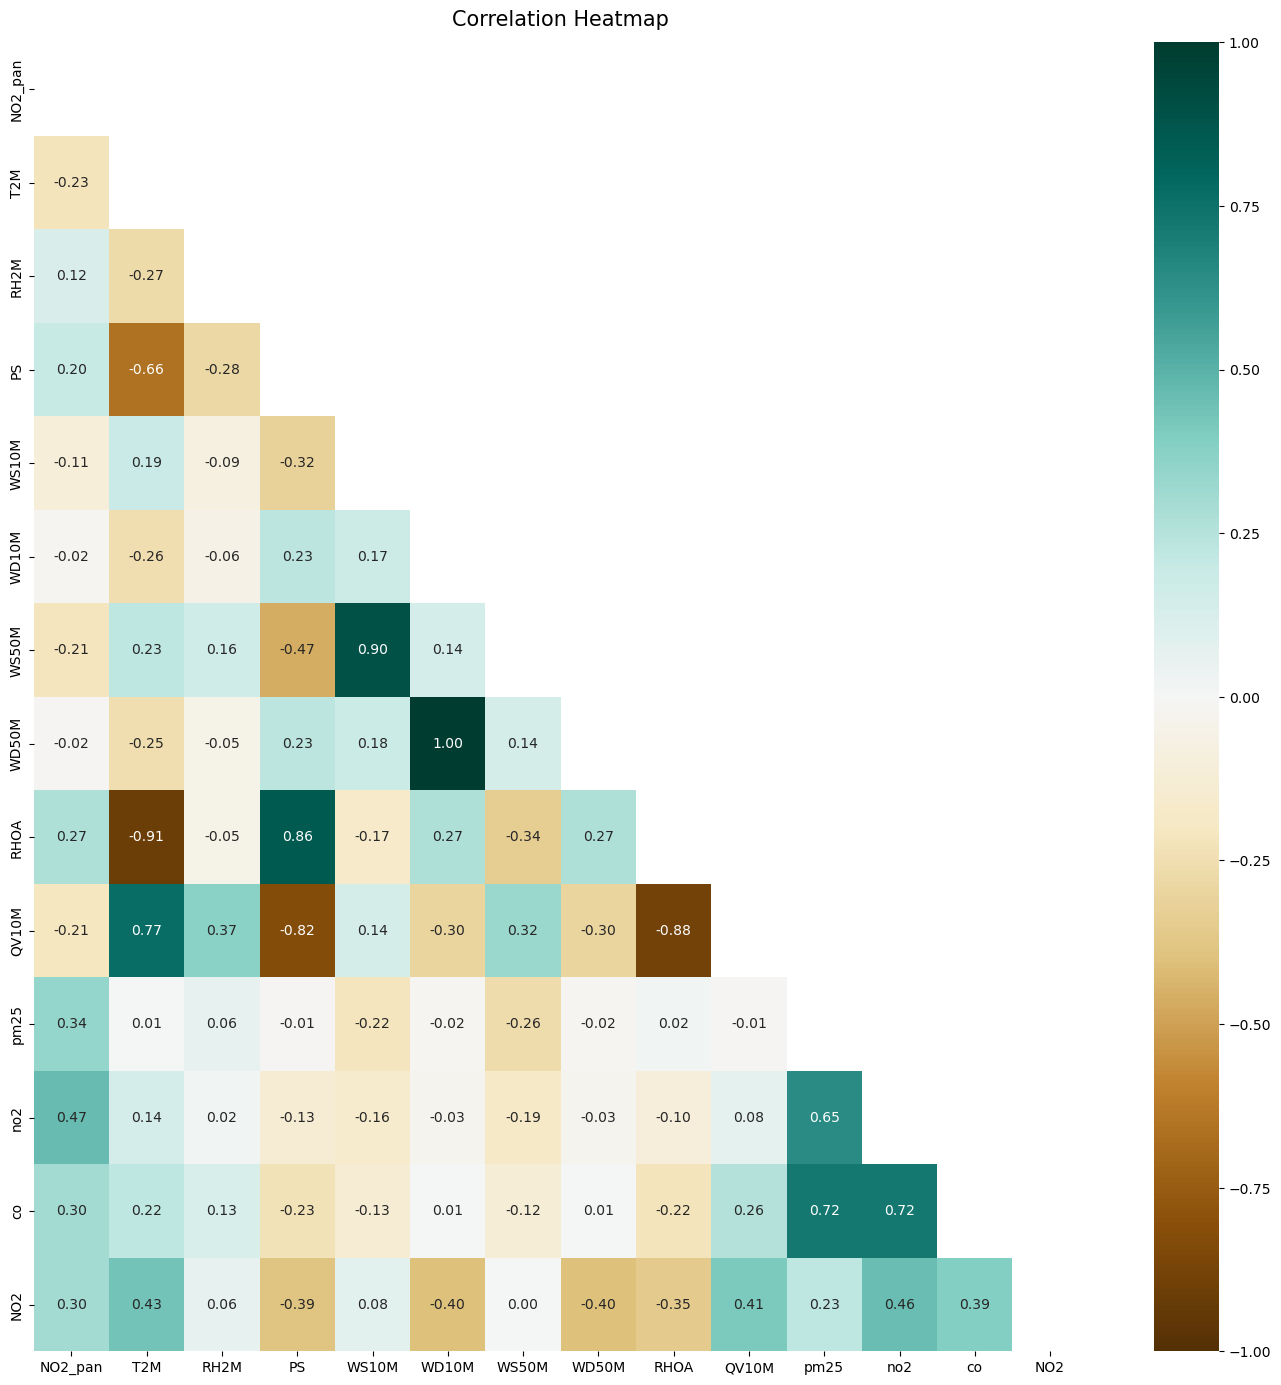

In [17]:
display(HTML("<b>Include Lunar Pandora data? </b><br>y/n"))
lunar = input().strip()
if lunar =='y':
    night_file_path = f'NO2_trop_col_night_Pandora_{start_date}_{end_date}_WashingtonDC_038.9218N_077.0124W.txt'
else: night_file_path = None

def parse_bool(s):
    return str(s).strip().lower() in {"y", "yes", "true", "t", "1"}

def only_date(s):
    s = str(s).strip().strip("'").strip('"')
    try:
        return datetime.strptime(s, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
    except ValueError:
        return s[:10]

sd = only_date(start_date)
ed = only_date(end_date)
include_lunar = parse_bool(lunar)


night_file_path = (
    f"NO2_trop_col_night_Pandora_{sd}_{ed}_{POI_name_}_038.9218N_077.0124W.txt"
    if include_lunar else None
)

day_file_path = f"NO2_trop_col_day_Pandora_{sd}_{ed}_{POI_name_}_038.9218N_077.0124W.txt"
df_day = pd.read_csv(day_file_path, sep=r"\s+", header=None, names=["year", "month", "day", "hour", "minute", "second", "NO2", "unc"])
df_day = df_day.groupby(["year", "month", "day", "hour"], as_index=False)["NO2"].mean()
df_day = df_day.rename(columns={"NO2": "NO2_day"})
df_day["datetime"] = pd.to_datetime(df_day[["year", "month", "day", "hour"]])

if include_lunar and night_file_path and os.path.exists(night_file_path):
    df_night = pd.read_csv(night_file_path, sep=r"\s+", header=None, names=["year", "month", "day", "hour", "minute", "second", "NO2"])
    df_night = df_night.groupby(["year", "month", "day", "hour"], as_index=False)["NO2"].mean()
    df_night = df_night.rename(columns={"NO2": "NO2_night"})
    df_night["datetime"] = pd.to_datetime(df_night[["year", "month", "day", "hour"]])

    # Outer merge day + night
    df = pd.merge(
        df_night[["datetime", "NO2_night"]],
        df_day[["datetime", "NO2_day"]],
        on="datetime",
        how="outer"
    )

    # use day where available, otherwise night
    df["NO2_pan"] = df["NO2_day"].combine_first(df["NO2_night"])

else:
    # Daytime only
    df = df_day[["datetime", "NO2_day"]].copy()
    df["NO2_pan"] = df["NO2_day"]

#remove extreme outliers
z = zscore(df["NO2_pan"].dropna())
valid_idx = df["NO2_pan"].dropna().index
outliers = valid_idx[(np.abs(z) > 3)]
df.loc[outliers, "NO2_pan"] = pd.NA

# Keep lightweight frame for inspection and plotting later
xx = df.copy()
if "NO2_night" not in xx:
    xx["NO2_night"] = pd.NA
if "NO2_day" not in xx:
    xx["NO2_day"] = pd.NA
xx = xx[["datetime", "NO2_day", "NO2_night"]]

power, airnow = None, None

for f in os.listdir("."):
    if f.startswith(f"POWER_METEO_{sd}_{ed}_{POI_name}"):
        try:
            power = power_processing(f, year=year, save=False, filename=f)
        except Exception as e:
            print(f"Could not load POWER file {f}. Check start date and end date: {e}")
            power = None
    if f.startswith(f"AIRNOW_COMPLETE_{sd}_{ed}_{POI_name_}"):
        try:
            airnow = pd.read_csv(f"AIRNOW_COMPLETE_{sd}_{ed}_{POI_name_}.csv")
        except Exception as e:
            print(f"Could not load AIRNOW file {f}. Check start date and end date: {e}")
            airnow = None

base = df[["datetime", "NO2_pan"]].copy()

if power is not None:
    power["datetime"] = pd.to_datetime(power["datetime"])
    pan_pow = pd.merge(base, power, on="datetime", how="right")
else:
    pan_pow = base

if airnow is not None:
    airnow["datetime"] = pd.to_datetime(airnow["datetime"])
    pan_pow_air = pd.merge(pan_pow, airnow, on="datetime", how="outer")
else:
    pan_pow_air = pan_pow

#TEMPO processing & merge
t = tempo_processing(
    f"NO2_trop_col_day_noneg_{sd}_{ed}_{POI_name_}_" + str("%08.4fN_%08.4fW" % (lat_, -lon_)) + ".txt",
    year, save=False, filename=""
).drop(columns=["year", "month", "day", "hour"])

t["datetime"] = pd.to_datetime(t["datetime"])
x = pd.merge(pan_pow_air, t, on="datetime", how="left")

#time-based interpolation for inpute features only 
x = x.sort_values("datetime").set_index("datetime")

ignores = ["NO2_pan", "NO2", "NO2_day", "NO2_night"] + list(t.columns.drop("datetime", errors="ignore"))
powerfeats = [c for c in x.columns if c not in ignores]

if powerfeats:
    x[powerfeats] = x[powerfeats].interpolate(method="time")

x = x.reset_index()

plot_correlation(x)
x["year"] = x["datetime"].dt.year
x["month"] = x["datetime"].dt.month
x["day"] = x["datetime"].dt.day
x["hour"] = x["datetime"].dt.hour


Using features: ['T2M', 'RH2M', 'PS', 'WS10M', 'WD10M', 'WS50M', 'WD50M', 'RHOA', 'QV10M', 'pm25', 'no2', 'co', 'year', 'month', 'day', 'hour']


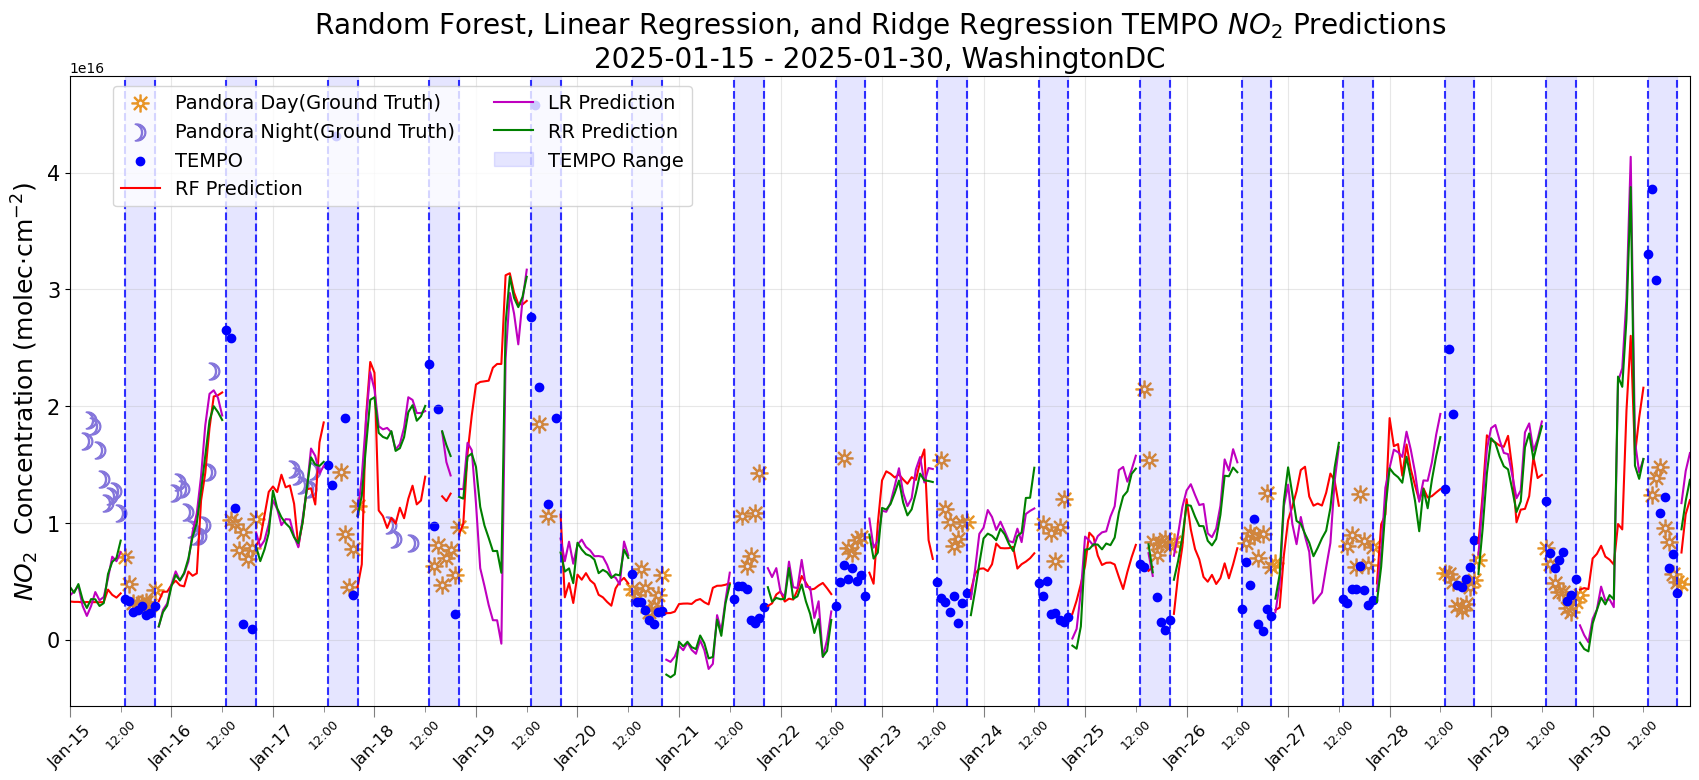

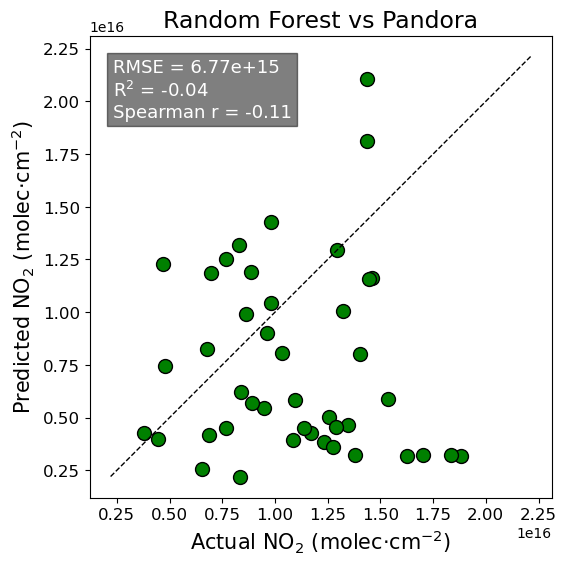

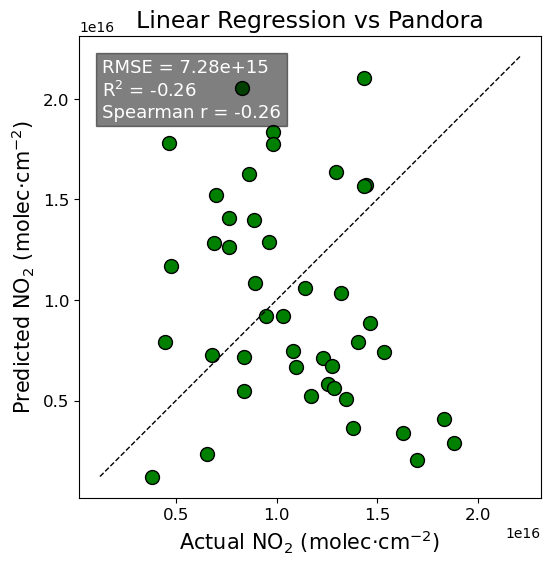

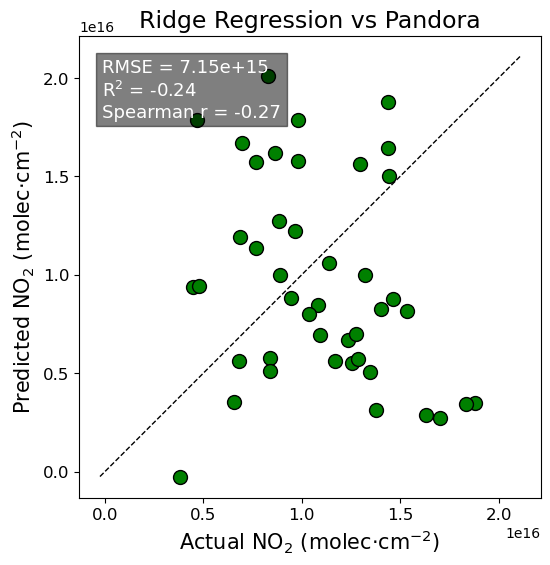

In [18]:
pred_df = predict_with_models(x, norm=False, save_model=False, output_dir="./")
visual_preds(pred_df,xx, save = True)
plot_scatters_vs_pandora(pred_df, save=True, prefix='washdc')

NameError: name 'pre' is not defined